## Goal: Predict Full season OBP best as possible. 

In [3]:
import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import sklearn

In [11]:
import os
%pwd
os.chdir('/Users/kylecamlic/Documents/Old Datasets:Files/')

df = pd.read_csv('obp.csv')
df.head()

,Name,playerid,birth_date,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,Trayce Thompson,9952,1991-03-15,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302
1,Mike Trout,10155,1991-08-07,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441
2,Bryce Harper,11579,1992-10-16,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
3,Chris Owings,10030,1991-08-12,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
4,Nick Fortes,21538,1996-11-11,34,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
profile = ProfileReport(df, minimal=True)
#Save to separate html file 
profile.to_file('profile.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
#Embed my html report into Jupyter
profile.to_notebook_iframe()

ydata-profiling is a fast, desciptive library we use to familiarize ourselves with the data.
Immediately we notice a huge problem: lots of missing data from  many different features, we will need to figure out a way to deal with these, as we cannot just delete these rows.


In [41]:
#Drop columns with that are not numerical for feature correlation
df_num = df.drop(columns=['Name', 'playerid', 'birth_date'])
df_num.head()

#Assess feature correlation with a heatmap, this is important for modeling/assessing multicollinearity
corr = df_num.corr()
corr.style.background_gradient(cmap='coolwarm')


,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
PA_21,1.000000,0.518741,0.601506,0.261735,0.524010,0.291671,0.481611,0.213371,0.380452,0.277676,0.253255,0.186908
OBP_21,0.518741,1.000000,0.373233,0.287140,0.306156,0.251801,0.255862,0.245985,0.121768,0.254812,0.131122,0.142072
PA_20,0.601506,0.373233,1.000000,0.386213,0.662376,0.365178,0.537765,0.266260,0.402826,0.268609,0.339452,0.166590
OBP_20,0.261735,0.287140,0.386213,1.000000,0.298196,0.249889,0.190588,0.156554,0.118078,0.284678,0.217161,0.074085
PA_19,0.524010,0.306156,0.662376,0.298196,1.000000,0.418409,0.604079,0.247112,0.477430,0.299478,0.378243,0.195989
OBP_19,0.291671,0.251801,0.365178,0.249889,0.418409,1.000000,0.234064,0.255430,0.155278,0.186124,0.197469,0.234053
PA_18,0.481611,0.255862,0.537765,0.190588,0.604079,0.234064,1.000000,0.367987,0.687543,0.401624,0.479091,0.240324
OBP_18,0.213371,0.245985,0.266260,0.156554,0.247112,0.255430,0.367987,1.000000,0.261153,0.366625,0.238304,0.189304
PA_17,0.380452,0.121768,0.402826,0.118078,0.477430,0.155278,0.687543,0.261153,1.000000,0.397299,0.667890,0.342664
OBP_17,0.277676,0.254812,0.268609,0.284678,0.299478,0.186124,0.401624,0.366625,0.397299,1.000000,0.345601,0.308147


In [42]:
#We dont have an alarming amount of multicollinearity present in our data, which is good.
#And in practice, if we did, ydata-profiling would alert us to this information as well.
df_num.head()

,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,35,0.400,NaN,NaN,NaN,NaN,137.0,0.162,55.0,0.218,262.0,0.302
1,146,0.466,241.0,0.390,600.0,0.438,608.0,0.460,507.0,0.442,681.0,0.441
2,599,0.429,244.0,0.420,682.0,0.372,695.0,0.393,492.0,0.413,627.0,0.373
3,50,0.420,44.0,0.318,196.0,0.209,309.0,0.272,386.0,0.299,466.0,0.315
4,34,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#Our biggest problem  is going to have to be addressed here: How to deal with an extremely large percentage of missing values
#Iteratively predict the missing columns, starting with features with the least missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(max_iter=10, random_state=42)
imputed_data = imputer.fit_transform(df_num)

print('Predicted features for the first row: ', imputed_data[0])

Predicted features for the first row:  [3.50000000e+01 4.00000000e-01 6.69541761e+01 2.81778045e-01
 1.68344032e+02 2.93130968e-01 1.37000000e+02 1.62000000e-01
 5.50000000e+01 2.18000000e-01 2.62000000e+02 3.02000000e-01]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [46]:
# Define column names
column_names = ["PA_21", "OBP_21", "PA_20", "OBP_20", "PA_19", "OBP_19", "PA_18", "OBP_18", "PA_17", "OBP_17","PA_16", "OBP_16"]

# Create a DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=column_names)
imputed_df.head()

,PA_21,OBP_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,35.0,0.400,66.954176,0.281778,168.344032,0.293131,137.000000,0.162000,55.000000,0.21800,262.000000,0.302000
1,146.0,0.466,241.000000,0.390000,600.000000,0.438000,608.000000,0.460000,507.000000,0.44200,681.000000,0.441000
2,599.0,0.429,244.000000,0.420000,682.000000,0.372000,695.000000,0.393000,492.000000,0.41300,627.000000,0.373000
3,50.0,0.420,44.000000,0.318000,196.000000,0.209000,309.000000,0.272000,386.000000,0.29900,466.000000,0.315000
4,34.0,0.353,56.139019,0.292264,155.728411,0.288408,158.942406,0.298773,174.266085,0.29393,149.186058,0.280627


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


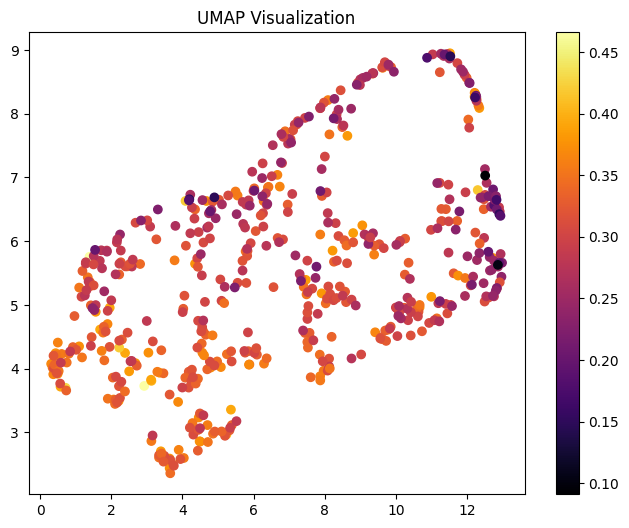

In [64]:
#Dimensionality reduction for visualization
from umap import UMAP
import umap.plot

#Create X as predictor features, y as the target feature, plot UMAP
X = imputed_df.drop(columns='OBP_21')
y = imputed_df['OBP_21']
mapper = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit(X)

%matplotlib inline
# Transform the data using UMAP
umap_embedding = mapper.transform(X)

# Create a scatter plot of the UMAP embedding
plt.figure(figsize=(8, 6))
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y, cmap='inferno')
plt.title("UMAP Visualization")
plt.colorbar()
plt.show()


In [73]:
#Dimensionality reduction has many purposes:
#1. To analyze high-dimensional data in a low-dimensional space 
#2. Helps Identify patterns, trends, clusters that may not be apparent in the high-dimensional data space.
#3. Since we imputed data, this helps us discern structure of the new dataset, and whether relationships and patterns are maintained from the high-dimensional space.
#4. In some cases, can be used as features for modeling to improve performance

#Umap df
# Create a DataFrame with UMAP dimensions
umap_df = pd.DataFrame(umap_embedding, columns=["UMAP1", "UMAP2"])
umap_df.head()

# Concatenate umap_df and X along the columns (axis=1)
df_umap_features_X = pd.concat([umap_df, X], axis=1)
df_umap_features_X.head()

,UMAP1,UMAP2,PA_21,PA_20,OBP_20,PA_19,OBP_19,PA_18,OBP_18,PA_17,OBP_17,PA_16,OBP_16
0,12.208402,8.268455,35.0,66.954176,0.281778,168.344032,0.293131,137.000000,0.162000,55.000000,0.21800,262.000000,0.302000
1,1.391341,5.756630,146.0,241.000000,0.390000,600.000000,0.438000,608.000000,0.460000,507.000000,0.44200,681.000000,0.441000
2,0.717516,3.700722,599.0,244.000000,0.420000,682.000000,0.372000,695.000000,0.393000,492.000000,0.41300,627.000000,0.373000
3,4.088419,6.631893,50.0,44.000000,0.318000,196.000000,0.209000,309.000000,0.272000,386.000000,0.29900,466.000000,0.315000
4,12.266368,8.223165,34.0,56.139019,0.292264,155.728411,0.288408,158.942406,0.298773,174.266085,0.29393,149.186058,0.280627


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train different regression models
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), 
          DecisionTreeRegressor(), RandomForestRegressor(), 
          GradientBoostingRegressor(), SVR(), KNeighborsRegressor()]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}, RMSE: {rmse}, R^2: {r2}")


Model: LinearRegression, RMSE: 0.045961588159820946, R^2: 0.3434921305172953
Model: Lasso, RMSE: 0.048348804300677214, R^2: 0.27352385392669
Model: Ridge, RMSE: 0.04619455433698707, R^2: 0.33681996143664483
Model: ElasticNet, RMSE: 0.047835550599267314, R^2: 0.28886601044562765
Model: DecisionTreeRegressor, RMSE: 0.05321253529990351, R^2: 0.12000990258851418
Model: RandomForestRegressor, RMSE: 0.04243584558406705, R^2: 0.4403511659393252
Model: GradientBoostingRegressor, RMSE: 0.04183603174477598, R^2: 0.45606018378813074
Model: SVR, RMSE: 0.051179984071291984, R^2: 0.18595169710166914
Model: KNeighborsRegressor, RMSE: 0.05027348510246554, R^2: 0.21453313666018647


In [79]:
#Try with normalized features 
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your predictor features (X)
X_scaled = scaler.fit_transform(X)


# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train different regression models
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), 
          DecisionTreeRegressor(), RandomForestRegressor(), 
          GradientBoostingRegressor(), SVR(), KNeighborsRegressor()]

for model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {model.__class__.__name__}, RMSE: {rmse}, R^2: {r2}")


Model: LinearRegression, RMSE: 0.04596158815982089, R^2: 0.3434921305172971
Model: Lasso, RMSE: 0.05672918521103181, R^2: -0.00014501425599955375
Model: Ridge, RMSE: 0.04596915653521142, R^2: 0.34327590182314915
Model: ElasticNet, RMSE: 0.05672918521103181, R^2: -0.00014501425599955375
Model: DecisionTreeRegressor, RMSE: 0.052834524285941466, R^2: 0.13246803571793653
Model: RandomForestRegressor, RMSE: 0.04204611471478304, R^2: 0.45058359332132225
Model: GradientBoostingRegressor, RMSE: 0.0423511965335879, R^2: 0.44258166198741655
Model: SVR, RMSE: 0.050149672063451355, R^2: 0.21839725249583508
Model: KNeighborsRegressor, RMSE: 0.046877579697131, R^2: 0.3170636263636327


So, using z-score transformations to scale our data, does not improve our predictions, and as a whole, our best model was the:
Model: GradientBoostingRegressor, RMSE: 0.04183603174477598, R^2: 0.45606018378813074.
This is a good improvement from our last submission with a score of RMSE: 0.053, likely do to using iterativeimputer instead of just replacing values with the mean,and also widening our variety of regression model choice. 

Our model explains 0.456 or 45.6% of variation in the dependent variable (OBP_21). 